# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, Mar 07, 5:00pm

**Late Penalty**:  Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Shiva Akbari <shiva.akbari@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:

In [2]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [3]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [4]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

C:\Users\Ethan's PC\AppData\Local\Temp\ipykernel_20564\1831985018.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [5]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [6]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [7]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [8]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [9]:
sel_header = ["age", "yredu", "capgain", "caploss", "workhr"]
minimums = np.zeros(len(sel_header))
maximums = np.zeros(len(sel_header))
averages = np.zeros(len(sel_header))
for i, col in enumerate(sel_header):
    minimums[i] = np.min(subdf[col])
    maximums[i] = np.max(subdf[col])
    averages[i] = np.average(subdf[col])
    # Normalize columns
    df[col] = (df[col] - minimums[i]) / (maximums[i] - minimums[i])

print(("Averages: {}").format(averages))
print(("Minimums: {}").format(minimums))
print(("Maximums: {}").format(maximums))

df[["age", "yredu", "capgain", "caploss", "workhr"]][:3]

Averages: [  38.58164676   10.08067934 1077.64884371   87.30382973   40.43745585]
Minimums: [17.  1.  0.  0.  1.]
Maximums: [9.0000e+01 1.6000e+01 9.9999e+04 4.3560e+03 9.9000e+01]


,age,yredu,capgain,caploss,workhr
0,0.301370,0.800000,0.02174,0.0,0.397959
1,0.452055,0.800000,0.00000,0.0,0.122449
2,0.287671,0.533333,0.00000,0.0,0.397959


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [10]:
# hint: you can do something like this in pandas
male_percentage = sum(df["sex"] == " Male") / df.shape[0]
female_percentage = sum(df["sex"] == " Female") / df.shape[0]
female_percentage

0.33079450876815825

### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [12]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [13]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [14]:
print(df_with_missing.shape) # 1843 records (rows) contained missing features
perc_of_removed = df_with_missing.shape[0]/df.shape[0] * 100
print(perc_of_removed) # 5.6% of records were removed from the dataframe

(1843, 11)
5.660145572924664


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [15]:
# Create a set of the possible values of the "work" feature within the dataset
possible_work = set(df_not_missing["work"])
possible_work

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [16]:
data = pd.get_dummies(df_not_missing) # Expands on features to create a column for every possible value in the feature, allowing us to assign a 0 or 1 to the column
# Function adds the feature_<possible value> column to the dataframe

In [21]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,50,13,0,0,13,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,38,9,0,0,40,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [17]:
data.shape 
# 57 features: One hot encoding expanded on the features selected to create a column for every possible value of each feature, allowing us to set the column value to 0 or 1 depending on the record.

(30718, 57)

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [18]:
datanp = data.values.astype(np.float32)
datanp

array([[0.30136988, 0.8       , 0.02174022, ..., 0.        , 0.        ,
        1.        ],
       [0.4520548 , 0.8       , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.28767124, 0.53333336, 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.56164384, 0.53333336, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.06849315, 0.53333336, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.47945204, 0.53333336, 0.15024151, ..., 1.        , 1.        ,
        0.        ]], dtype=float32)

In [19]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take (from one hot encoding, we have all the values for the feature as seperate columns. Can store dictionary of feature
                # and it's possible values prior to the encoding)

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    max_val_ind = np.argmax(onehot)
    max_feature = cat_values[feature][max_val_ind]
    return max_feature


In [20]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [21]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
from torch.utils.data.sampler import SubsetRandomSampler
np.random.seed(50)

data_size = len(datanp)
batch_size = 32

# Create train, validation, test samplers - sets of random indices from the dataset (70% train, 15% validation, 15% test) that are provided to a sampler function when loading the data into the data object
# based on batch size and the provided data tensor
data_inds = np.arange(0,data_size)
np.random.shuffle(data_inds)
split = int(data_size*0.7)
split2 = int((data_size-split)/2)
train_sampler = SubsetRandomSampler(data_inds[:split])
val_sampler = SubsetRandomSampler(data_inds[split:(split+split2)])
test_sampler = SubsetRandomSampler(data_inds[(split+split2):])
# Convert numpy data to torch tensor for inputs to loaders
data_torch = torch.from_numpy(datanp)
train_loader = torch.utils.data.DataLoader(data_torch, batch_size=batch_size, num_workers=1, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_torch, batch_size=batch_size, num_workers=1, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(data_torch, batch_size=batch_size, num_workers=1, sampler=test_sampler)


In [22]:
# Note that the sizes given here are based on a batch size of 32. With a batch size of one, training = 21502 records, validation = 4608 records, test = 4608 records
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

672
144
144


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [30]:
from torch import nn
# Autoencoders follow the hourglass architecture shape. Want to use that when designing this architecture, so instead of reducing the dimensionality alot in one shot, can reduce in multiple layer steps
class AutoEncoder(nn.Module):
    def __init__(self):
        self.name = "autoencoder"
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 42),
            nn.ReLU(),
            nn.Linear(42, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 20),
            nn.ReLU(),
            nn.Linear(20, 30),
            nn.ReLU(),
            nn.Linear(30, 42),
            nn.ReLU(),
            nn.Linear(42, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [ ]:
# The sigmoid activation function is used in the last step of the decoder to get the results within the range of 0-1. This gives us probabilities of a particular column being true, since the data
# dataframe stores the one hot encoding of the possible characteristics different people can have.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [40]:
import matplotlib.pyplot as plt
import time

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def evaluate(model, loader, criterion):
    """Evaluate model performance on provided loader. Return loss and accuracy of the model"""
    total_loss = 0
    total_size = 0
    for data in loader:
        datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
        reconstruction = model(datam)
        loss = criterion(reconstruction, data)
        total_loss += loss.item() # Extract loss as a float
        total_size += datam.shape[0]
    loss = total_loss / total_size
    return loss

def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop """
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    training_loss = np.zeros(num_epochs)
    validation_loss = np.zeros(num_epochs)
    training_acc = np.zeros(num_epochs)
    validation_acc = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_size = 0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            reconstruction = model(datam)
            loss = criterion(reconstruction, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Calculate training loss for batch
            total_loss += loss.item() # Extract loss as a float
            total_size += datam.shape[0]
        # Store loss and accuracies for training and validation sets
        training_loss[epoch] = total_loss / total_size
        validation_loss[epoch] = evaluate(model, valid_loader, criterion)
        training_acc[epoch] = get_accuracy(model, train_loader)
        validation_acc[epoch] = get_accuracy(model, val_loader)

        # Print out epoch information regarding error and loss
        print(("Epoch {}: Train loss: {} |" "Validation loss: {}").format(epoch + 1, training_loss[epoch], validation_loss[epoch]))
        # Save the current model (checkpoint) to a file and plot training/validation loss every epoch
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Plot loss and accuracy over epochs
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,num_epochs+1), training_loss, label="Train")
    plt.plot(range(1,num_epochs+1), validation_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(range(1,num_epochs+1), training_acc, label="Train")
    plt.plot(range(1,num_epochs+1), validation_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1: Train loss: 0.004559157254925751 |Validation loss: 0.002226092071699289
Epoch 2: Train loss: 0.002198916946984526 |Validation loss: 0.0021771849222002653
Epoch 3: Train loss: 0.002130010761698283 |Validation loss: 0.002057175322584549
Epoch 4: Train loss: 0.0019100308466784822 |Validation loss: 0.0017740806862194505
Epoch 5: Train loss: 0.001733776903016081 |Validation loss: 0.00169155900786993
Finished Training
Total time elapsed: 198.74 seconds


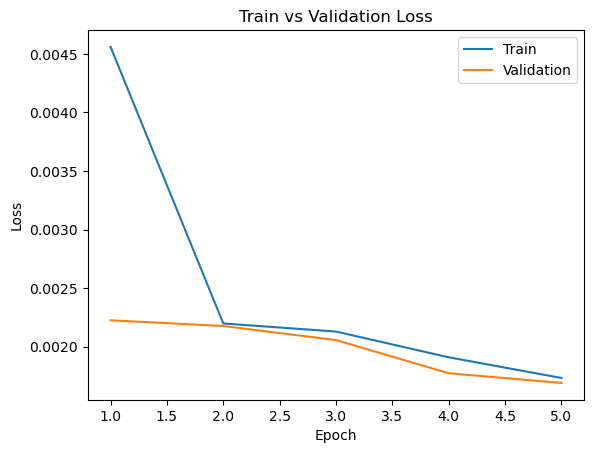

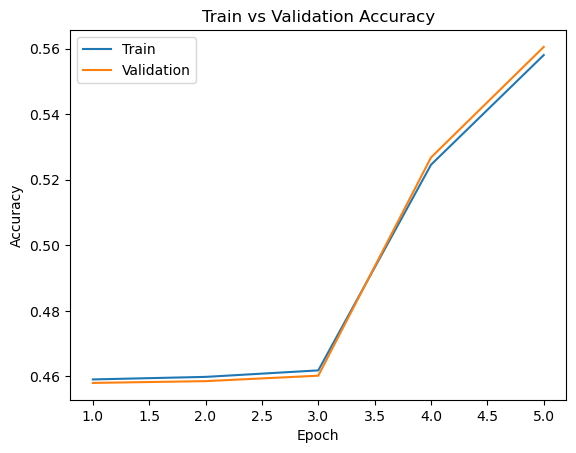

In [35]:
model = AutoEncoder()
train(model, train_loader, val_loader)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

Epoch 1: Train loss: 0.0022741767325137187 |Validation loss: 0.001636840843679642
Epoch 2: Train loss: 0.0015270734532770807 |Validation loss: 0.0014534095712911545
Epoch 3: Train loss: 0.0013836431955902557 |Validation loss: 0.0013378892334811906
Epoch 4: Train loss: 0.0012977413204925225 |Validation loss: 0.0012682318661568894
Epoch 5: Train loss: 0.0012499993488035938 |Validation loss: 0.0012367482890517244
Epoch 6: Train loss: 0.0012187324465187403 |Validation loss: 0.0012063226648832723
Epoch 7: Train loss: 0.0011833956803488583 |Validation loss: 0.001165140628775892
Epoch 8: Train loss: 0.0011531719049131656 |Validation loss: 0.001146509491566879
Epoch 9: Train loss: 0.0011342355967435644 |Validation loss: 0.0011139057783616914
Epoch 10: Train loss: 0.001115496844779546 |Validation loss: 0.0011116633201406028
Epoch 11: Train loss: 0.001083029578318181 |Validation loss: 0.0010771767370493358
Epoch 12: Train loss: 0.0010569941067262345 |Validation loss: 0.0010690200207237569
Epoch 

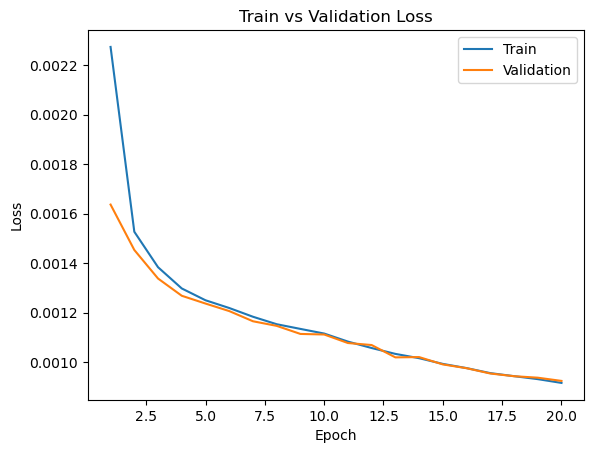

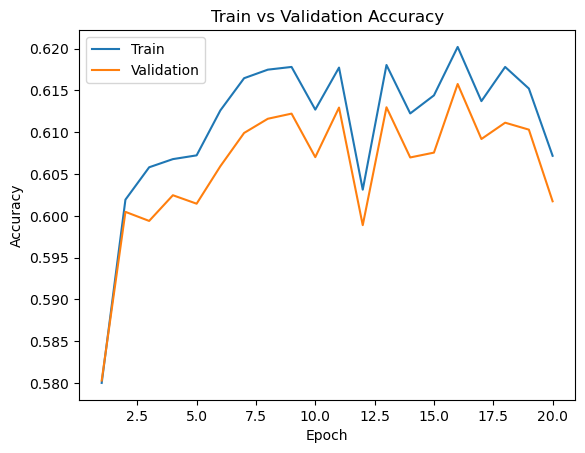

In [36]:
model = AutoEncoder()
train(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001)

Epoch 1: Train loss: 0.004572604501256276 |Validation loss: 0.0022426775701913154
Epoch 2: Train loss: 0.002206008919446194 |Validation loss: 0.0021789935910621555
Epoch 3: Train loss: 0.0021431785405691185 |Validation loss: 0.002079551231872756
Epoch 4: Train loss: 0.0019056324749760888 |Validation loss: 0.001793808328835035
Epoch 5: Train loss: 0.0017552807093437256 |Validation loss: 0.0017185457359624302
Epoch 6: Train loss: 0.0016871355271288965 |Validation loss: 0.0016589697988820262
Epoch 7: Train loss: 0.0016521782454984397 |Validation loss: 0.001625836189001954
Epoch 8: Train loss: 0.0016286256485315892 |Validation loss: 0.001614863503265143
Epoch 9: Train loss: 0.0016109212694523135 |Validation loss: 0.0015998757032017845
Epoch 10: Train loss: 0.0015983611780849682 |Validation loss: 0.0015857404998516561
Epoch 11: Train loss: 0.001581140290472787 |Validation loss: 0.001566177230011413
Epoch 12: Train loss: 0.001558202070835224 |Validation loss: 0.001538768628152967
Epoch 13: T

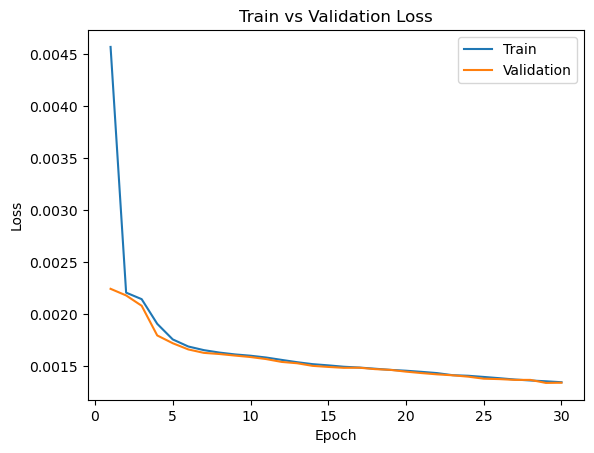

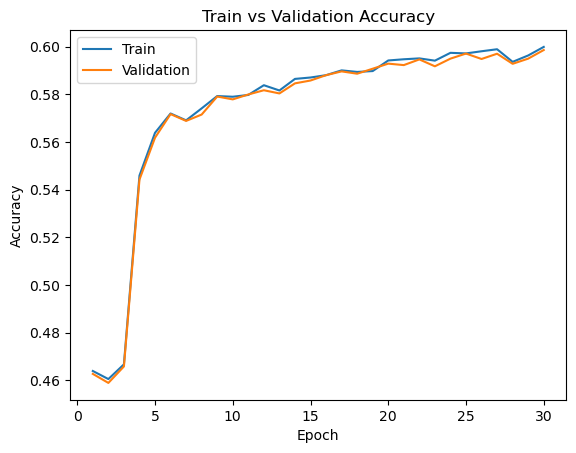

In [37]:
model = AutoEncoder()
train(model, train_loader, val_loader, num_epochs=30, learning_rate=0.0001)

Epoch 1: Train loss: 0.003101170439671255 |Validation loss: 0.0013442333632459242
Epoch 2: Train loss: 0.0011469245472571737 |Validation loss: 0.0011099065902979216
Epoch 3: Train loss: 0.0011044809434144689 |Validation loss: 0.0010995098499632957
Epoch 4: Train loss: 0.0010935469239370822 |Validation loss: 0.0010851388910345526
Epoch 5: Train loss: 0.0010746657235388335 |Validation loss: 0.0010590211321767936
Epoch 6: Train loss: 0.0010263778273795507 |Validation loss: 0.0009734436648108789
Epoch 7: Train loss: 0.0009221911042964732 |Validation loss: 0.0008861788325399781
Epoch 8: Train loss: 0.0008689118842891887 |Validation loss: 0.0008515973499419892
Epoch 9: Train loss: 0.0008420618033533306 |Validation loss: 0.0008271753079801177
Epoch 10: Train loss: 0.0008119406751541967 |Validation loss: 0.0008002038359538548
Epoch 11: Train loss: 0.0007978747575870836 |Validation loss: 0.0007889255308934177
Epoch 12: Train loss: 0.0007877424906801705 |Validation loss: 0.000784988528822497
Epo

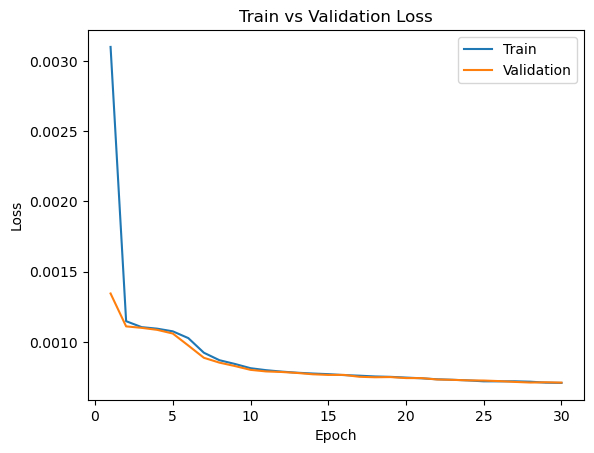

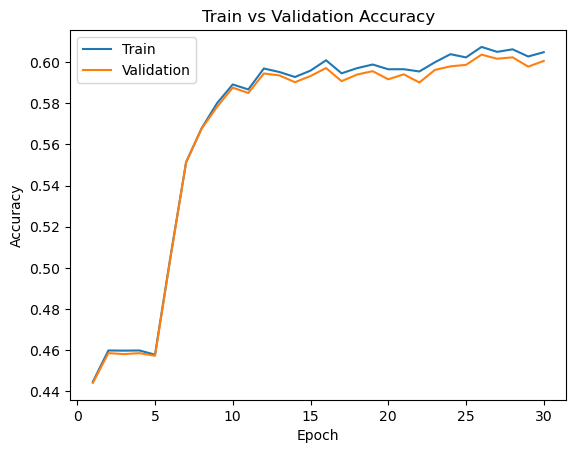

In [38]:
train_loader = torch.utils.data.DataLoader(data_torch, batch_size=64, num_workers=1, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_torch, batch_size=64, num_workers=1, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(data_torch, batch_size=64, num_workers=1, sampler=test_sampler)

model = AutoEncoder()
train(model, train_loader, val_loader, num_epochs=30, learning_rate=0.0001)

Epoch 1: Train loss: 0.0013944731418706242 |Validation loss: 0.0009756932761067421
Epoch 2: Train loss: 0.0008646224509069126 |Validation loss: 0.0008082058161057325
Epoch 3: Train loss: 0.0007691910609418587 |Validation loss: 0.0007289934364962392
Epoch 4: Train loss: 0.0007041557137147957 |Validation loss: 0.0006816644462459306
Epoch 5: Train loss: 0.0006664985271608892 |Validation loss: 0.0006595941667910665
Epoch 6: Train loss: 0.0006434367130220397 |Validation loss: 0.000637977862627142
Epoch 7: Train loss: 0.0006310922780551751 |Validation loss: 0.0006337287462277649
Epoch 8: Train loss: 0.0006226071381530654 |Validation loss: 0.0006197005883829357
Epoch 9: Train loss: 0.0006104814568341316 |Validation loss: 0.000601194144918635
Epoch 10: Train loss: 0.0005952950718430361 |Validation loss: 0.0005934937443170282
Epoch 11: Train loss: 0.0005831195736455869 |Validation loss: 0.0005773815614197196
Epoch 12: Train loss: 0.0005700416858113541 |Validation loss: 0.0005663877899577427
Epo

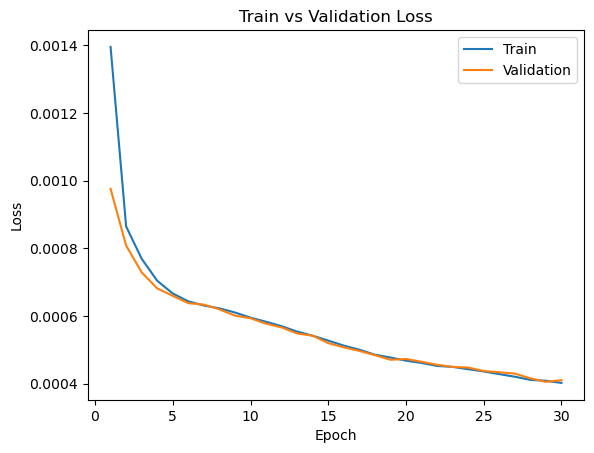

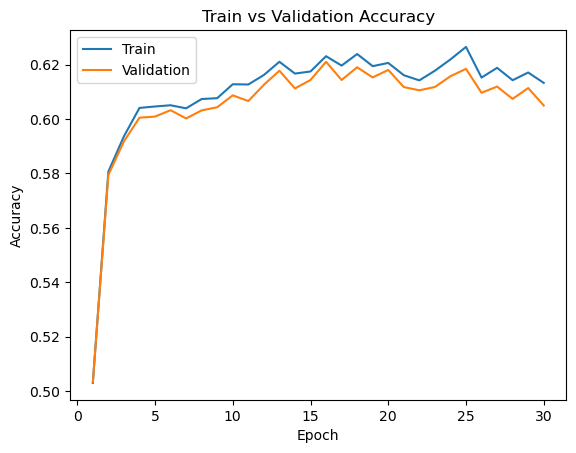

In [39]:
model = AutoEncoder()
train(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [41]:
test_accuracy = get_accuracy(model, test_loader) # Best model: 30 epochs, lr = 0.001, batch size = 64
test_accuracy

0.6101707175925926

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?